In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset/final_augmented_headlines.csv


In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    required_columns = {'headline', 'is_sarcastic'}
    assert required_columns.issubset(df.columns), \
        f"Dataset must contain the following columns: {required_columns}"
    return df

# Custom Dataset Class
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer(
            row['headline'], 
            max_length=self.max_len, 
            padding='max_length', 
            truncation=True, 
            return_tensors='pt'
        )
        label = torch.tensor(row['is_sarcastic'], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': label
        }

# Load Data
data_path = "/kaggle/input/news-headlines-dataset/final_augmented_headlines.csv"  # Replace with actual file path
df = load_data(data_path)

# Train-Test Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Datasets and DataLoaders
train_dataset = SarcasmDataset(train_df, tokenizer)
val_dataset = SarcasmDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model Initialization
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=num_training_steps
)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# Evaluation Loop
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask=attention_mask).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 4007/4007 [13:28<00:00,  4.96it/s]


Epoch 1 Loss: 0.2174


Epoch 2/3: 100%|██████████| 4007/4007 [13:26<00:00,  4.97it/s]


Epoch 2 Loss: 0.0575


Epoch 3/3: 100%|██████████| 4007/4007 [13:27<00:00,  4.96it/s]


Epoch 3 Loss: 0.0156
Validation Accuracy: 0.9913
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9052
           1       0.99      0.99      0.99      6974

    accuracy                           0.99     16026
   macro avg       0.99      0.99      0.99     16026
weighted avg       0.99      0.99      0.99     16026



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 4007/4007 [13:24<00:00,  4.98it/s]


Epoch 1 Loss: 0.2214


Epoch 2/3: 100%|██████████| 4007/4007 [13:26<00:00,  4.97it/s]


Epoch 2 Loss: 0.0586


Epoch 3/3: 100%|██████████| 4007/4007 [13:26<00:00,  4.97it/s]


Epoch 3 Loss: 0.0168


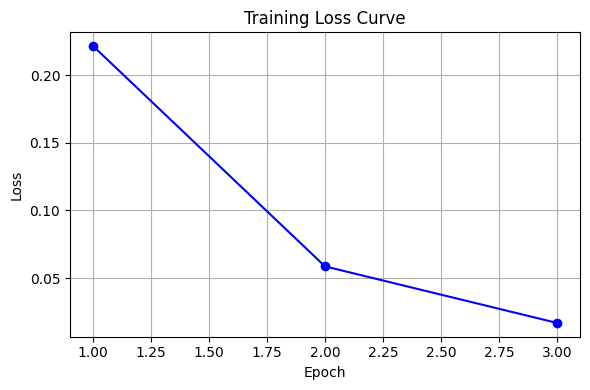

Validation Accuracy: 0.9917
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9052
           1       0.99      0.99      0.99      6974

    accuracy                           0.99     16026
   macro avg       0.99      0.99      0.99     16026
weighted avg       0.99      0.99      0.99     16026



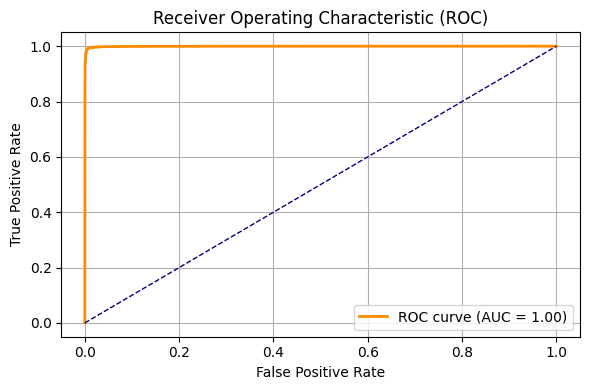

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import softmax

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    required_columns = {'headline', 'is_sarcastic'}
    assert required_columns.issubset(df.columns), \
        f"Dataset must contain the following columns: {required_columns}"
    return df

# Custom Dataset Class
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer(
            row['headline'],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        label = torch.tensor(row['is_sarcastic'], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': label
        }

# Load Data
data_path = "/kaggle/input/news-headlines-dataset/final_augmented_headlines.csv"  # Update path if needed
df = load_data(data_path)

# Train-Test Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Datasets and DataLoaders
train_dataset = SarcasmDataset(train_df, tokenizer)
val_dataset = SarcasmDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model Initialization
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Training Loop with Loss Tracking
loss_values = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), loss_values, marker='o', color='blue')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation Loop with ROC Data
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask=attention_mask).logits
        probs = softmax(logits, dim=1)[:, 1]  # Probability of sarcastic class
        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy and Classification Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))

# ROC Curve Plot
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 4007/4007 [07:17<00:00,  9.15it/s]


Epoch 1 Loss: 0.2199


Epoch 2/3: 100%|██████████| 4007/4007 [07:17<00:00,  9.16it/s]


Epoch 2 Loss: 0.0366


Epoch 3/3: 100%|██████████| 4007/4007 [07:17<00:00,  9.16it/s]


Epoch 3 Loss: 0.0085


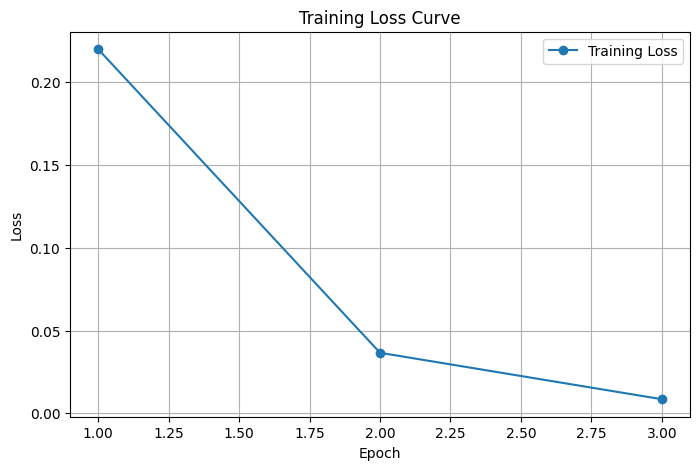

Validation Accuracy: 0.9925
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9052
           1       0.99      0.99      0.99      6974

    accuracy                           0.99     16026
   macro avg       0.99      0.99      0.99     16026
weighted avg       0.99      0.99      0.99     16026



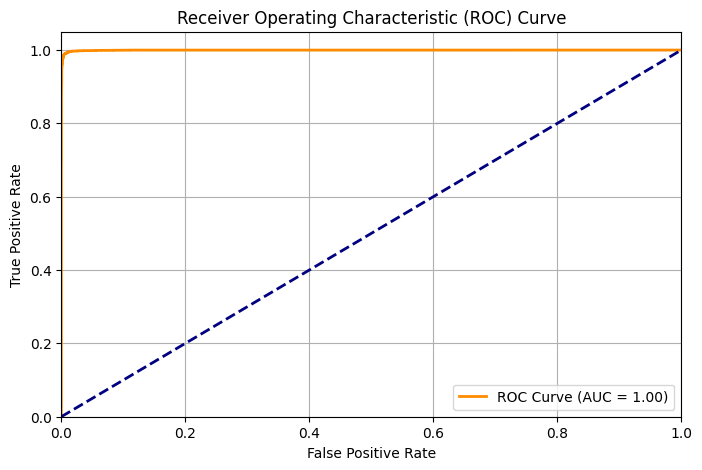

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    required_columns = {'headline', 'is_sarcastic'}
    assert required_columns.issubset(df.columns), \
        f"Dataset must contain the following columns: {required_columns}"
    return df

# Custom Dataset Class
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer(
            row['headline'], 
            max_length=self.max_len, 
            padding='max_length', 
            truncation=True, 
            return_tensors='pt'
        )
        label = torch.tensor(row['is_sarcastic'], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': label
        }

# Load Data
data_path = "/kaggle/input/news-headlines-dataset/final_augmented_headlines.csv"  # Replace with actual file path
df = load_data(data_path)

# Train-Test Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Datasets and DataLoaders
train_dataset = SarcasmDataset(train_df, tokenizer)
val_dataset = SarcasmDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=num_training_steps
)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Track training loss
train_losses = []

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# Plot Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Loop
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]  # Probability of class 1
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Accuracy and Classification Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
